In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

# A/B Testing

In [2]:
births = Table.read_table('baby.csv')

In [3]:
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [5]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')

In [6]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


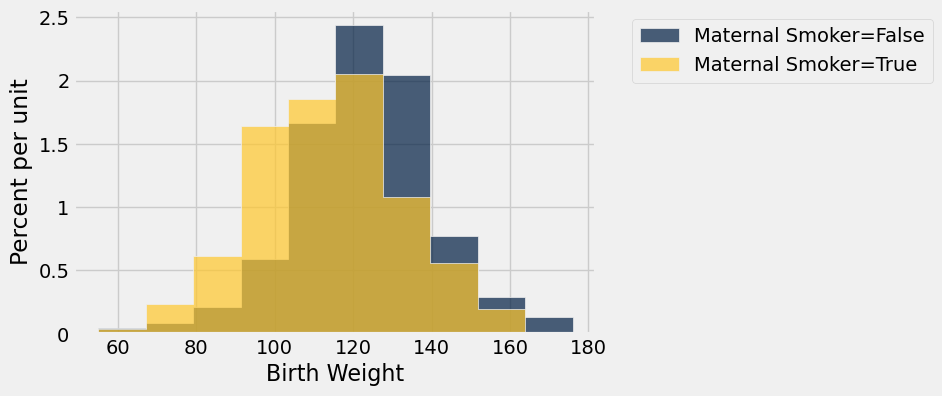

In [7]:
#Use histogram when numerical variable
# Use overlapping histogram for numerical groups
# Whenever you have a histogram you should be able to talk about shape, symmetry, and whether you have the presebce/absence of outliers 

smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

# Test Statistic

[Question] What values of our statistic are in favor of the alternative: positive or negative?

In [8]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [9]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

In [10]:
def difference_of_means(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [11]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Random Permutation (Shuffling)

In [12]:
letters = Table().with_column('Letter', make_array('a', 'b', 'c', 'd', 'e'))

In [13]:
letters.sample()

Letter
a
b
e
c
e


In [14]:
letters.sample(with_replacement = False)

Letter
e
c
a
d
b


In [15]:
letters.with_column('Shuffled', letters.sample(with_replacement = False).column(0))

Letter,Shuffled
a,d
b,e
c,c
d,a
e,b


# Simulation Under Null Hypothesis

In [16]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [30]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False
                                                ).column('Maternal Smoker')

In [18]:
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels
)

In [19]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,True
False,113,True
True,128,True
True,108,True
False,136,False
False,138,False
False,132,False
False,120,True
True,143,True
False,140,False


In [20]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

0.8217042217042234

In [21]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

# Permutation Test

In [22]:
def one_simulated_difference(table, label, group_label):
    """Takes: name of table, column label of numerical variable,
    column label of group-label variable
    Returns: Difference of means of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False
                                                    ).column(group_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(label).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, label, 'Shuffled Label')   

In [23]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

-0.7773268126209274

In [28]:
differences = make_array()

for i in np.arange(1000):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


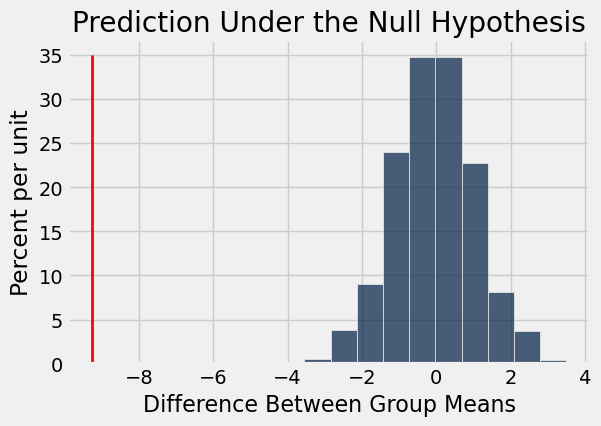

In [29]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');
plots.plot([observed_difference, observed_difference], [0, .35], color='red', lw=2);

In [26]:
sum(differences <= observed_difference)/5000

0.0

In [27]:
min(differences)

-3.9181528710940512